In [1]:
#Pindah direktori ke direktori tempat data 
import os
path = 'E:\Daily Reanalisis ERA 5 v2'
os.chdir(path)

In [2]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.ticker as tk
import matplotlib.patches as mpatches
from scipy import stats

In [4]:
def bootstrap_3dxr(data, sample_size, n_samples, percentile):
    
    # create a list for sample means
    sample_means = []
    
    # loop n_samples times
    for i in tqdm(range(n_samples)):
        t=data.time
        trand=np.random.choice(t, size=sample_size, replace=False)
        datarandmean=data.sel(time=np.in1d(data.time,trand)).mean(dim='time')
        sample_means.append(datarandmean.values)
        
    low=np.percentile(sample_means,percentile/2, axis=0)
    high=np.percentile(sample_means,100-percentile/2, axis=0)
    
    return low, high #2D low and high threshold

In [5]:
#Read MJO excel
mjoevt=pd.read_excel('data/MJO BOM.xlsx')

In [28]:
#Get each MJO phase event climatology
tglcensmjoph=mjoevt.set_index(['amplitude', 'phase'])
tglcensmjoamp05=tglcensmjoph[tglcensmjoph.index.get_level_values('amplitude')>=1]
tglmjoeveryph=[]
for i in range(8):
    tgl=tglcensmjoamp05[tglcensmjoamp05.index.get_level_values('phase')==i+1]
    tglmjoeveryph.append(tgl['Tanggal'].values)

In [7]:
#Read data
datav925 = xr.open_mfdataset('v925\*.nc',combine = 'by_coords')
datau925 = xr.open_mfdataset('u925\*.nc',combine = 'by_coords')
datamslp = xr.open_mfdataset('mslp\*.nc',combine = 'by_coords')
dataolr = xr.open_dataset('E:\CobaWK99\olr.day.mean.nc')

In [8]:
v925=datav925['v'].sel(lat=slice(-20,22), lon=slice(82,138), time=slice('1981-12-01T00:00:00.000000000','2021-02-28T00:00:00.000000000'))
u925=datau925['u'].sel(lat=slice(-20,22), lon=slice(82,138),time=slice('1981-12-01T00:00:00.000000000','2021-02-28T00:00:00.000000000'))
mslp=datamslp['msl'].sel(lat=slice(-20,22), lon=slice(82,138),time=slice('1981-12-01T00:00:00.000000000','2021-02-28T00:00:00.000000000'))/100
olr=dataolr['olr'].sel(lat=slice(22,-22), lon=slice(82,138),time=slice('1981-12-01T00:00:00.000000000','2021-02-28T00:00:00.000000000'))
lat=v925['lat'].values
lon=v925['lon'].values
latolr=olr['lat'].values
lonolr=olr['lon'].values
#Anomalies
climv925 = v925.groupby('time.season').mean('time')
anv925 = v925.groupby('time.season') - climv925
climu925 = u925.groupby('time.season').mean('time')
anu925 = u925.groupby('time.season') - climu925
climslp = mslp.groupby('time.season').mean('time')
anslp = mslp.groupby('time.season') - climslp
climolr = olr.groupby('time.season').mean('time')
anolr = olr.groupby('time.season') - climolr
anv925djf = anv925.sel(time=anv925.time.dt.season=="DJF")
anu925djf = anu925.sel(time=anu925.time.dt.season=="DJF")
anslpdjf = anslp.sel(time=anslp.time.dt.season=="DJF")
anolrdjf = anolr.sel(time=anolr.time.dt.season=="DJF")
v925djfclim= anv925djf.load()
u925djfclim=  anu925djf.load()
slpdjfclim= anslpdjf.load()
olrdjfclim= anolrdjf.load()

In [9]:
lat=v925['lat'].values
lon=v925['lon'].values

In [10]:
pvaluemslp=np.empty([8, len(np.arange(0,len(lat),6)), len(np.arange(0,len(lon),6))])
data=slpdjfclim[:,::6,::6]
for c in range(8):
    low, high = bootstrap_3dxr(data, len(tglmjoeveryph[c]), 1000, 1)
    compositemean=slpdjfclim[:,::6,::6].sel(time=np.in1d(slpdjfclim.time, tglmjoeveryph[c])).mean(dim='time')
    pvaluemslp[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluemslptf=pvaluemslp

pvalueu925=np.empty([8, len(np.arange(0,len(lat),13)), len(np.arange(0,len(lon),13))])
data=u925djfclim[:,::13,::13]
for c in range(8):
    low, high = bootstrap_3dxr(data, len(tglmjoeveryph[c]), 1000, 1)
    compositemean=u925djfclim[:,::13,::13].sel(time=np.in1d(u925djfclim.time, tglmjoeveryph[c])).mean(dim='time')
    pvalueu925[c]=np.logical_or(compositemean<low, compositemean>high).values
pvalueu925tf=pvalueu925

pvaluev925=np.empty([8, len(np.arange(0,len(lat),13)), len(np.arange(0,len(lon),13))])
data=v925djfclim[:,::13,::13]
for c in range(8):
    low, high = bootstrap_3dxr(data, len(tglmjoeveryph[c]), 1000, 1)
    compositemean=v925djfclim[:,::13,::13].sel(time=np.in1d(v925djfclim.time, tglmjoeveryph[c])).mean(dim='time')
    pvaluev925[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluev925tf=pvaluev925

pvalueuv925tf=np.logical_or(pvalueu925tf, pvaluev925tf)
pvalueuv925tf=pvalueuv925tf.astype(float)
pvalueuv925tf[pvalueuv925tf==0] = np.nan

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.34it/s]


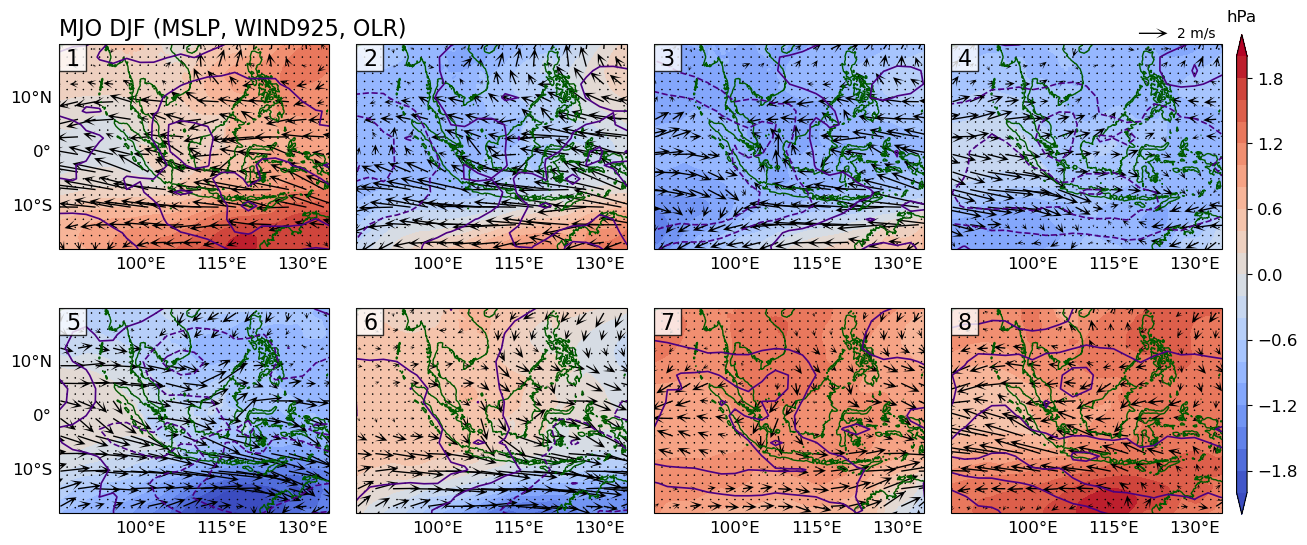

In [44]:
fig = plt.figure(figsize=(15,8))
for img, sbp in zip(np.arange(0,8,1), np.arange(241,249,1)):
    ax = fig.add_subplot(sbp, projection=ccrs.PlateCarree())
    ax.set_extent([85, 135, -18, 20], crs=ccrs.PlateCarree())
    gl=ax.gridlines(draw_labels=True,linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = tk.FixedLocator([85, 100, 115, 130])
    gl.ylocator = tk.FixedLocator([ -10, 0, 10])
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    if img == 1 or img == 2 or img == 3 or img==5 or img==6 or img==7:
        gl.left_labels = False
    pltctr=ax.contour(lonolr, latolr, olrdjfclim.sel(time=np.in1d(olrdjfclim.time, tglmjoeveryph[img])).mean(dim='time'), 
              transform=ccrs.PlateCarree(),
              #add_colorbar= False,
              levels= [-20,-10,0,10,20], 
              extend='both', colors='indigo', linewidths=1.2
              )
    #ax.clabel(pltctr, pltctr.levels, inline=True, fontsize=10, colors='indigo')
    dset=slpdjfclim
    value=dset.sel(time=np.in1d(dset.time, tglmjoeveryph[img])).mean(dim='time')
    plotval=ax.contourf(lon, lat, value, transform=ccrs.PlateCarree(),
              cmap='coolwarm',
              #add_colorbar= False,
              levels=np.arange(-2,2.2,0.2), extend='both'
              )
    x,y=np.meshgrid(lon, lat)
    skipp=6
    ax.scatter(x[::skipp,::skipp],y[::skipp,::skipp],pvaluemslptf[img]*1*0.5,color='k', linewidth=0.4)
    uu=u925djfclim.sel(time=np.in1d(u925djfclim.time, tglmjoeveryph[img])).mean(dim='time')
    vv=v925djfclim.sel(time=np.in1d(v925djfclim.time, tglmjoeveryph[img])).mean(dim='time')
    skip = 13
    #Qwd=ax.quiver(x[::skip, ::skip], y[::skip, ::skip], uu[::skip, ::skip], vv[::skip, ::skip], color='k', scale=7 ,scale_units='inches', width=0.005, headlength=8.5, headwidth=7.5, headaxislength=4)
    Qwd=ax.quiver(x[::skip, ::skip], y[::skip, ::skip], uu[::skip, ::skip]*pvalueuv925tf[img], vv[::skip, ::skip]*pvalueuv925tf[img], color='k', scale=7 ,scale_units='inches', width=0.005, headlength=8.5, headwidth=7.5, headaxislength=4)

    ax.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
    if img==0:
        ax.set_title('MJO DJF (MSLP, WIND925, OLR)', loc='left', fontsize=16)
    longitude1, latitude1 = 85, 15
    longitude2, latitude2 = 90, 20

    ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                    facecolor='white', edgecolor='k', linewidth=1, alpha=0.8, zorder=3,
                                    transform=ccrs.PlateCarree()))
    ax.text(86.25,16,str(1+img),fontsize=16, c='k')
    if img==3:
        qk = plt.quiverkey(Qwd, 
                  0.8, 1.05,                  
                  2,str(2)+' m/s',   
                  labelpos='E',               
                  coordinates='axes'
                   )
    
cbar_ax = fig.add_axes([0.91, 0.2, 0.007, 0.6])
cbar = fig.colorbar(plotval, cax=cbar_ax)
cbar.ax.set_title('hPa', pad=25, fontsize=12)
cbar.ax.tick_params(labelsize=12)



plt.subplots_adjust(hspace=-0.25, wspace=0.1)
#plt.savefig('E:\Daily Reanalisis ERA 5 v2\Revisi\Fase MJO.jpg', dpi=200, bbox_inches='tight')
#plt.savefig('E:\Daily Reanalisis ERA 5 v2\Gambar Publikasi\Fase MJO.eps', format='eps', bbox_inches='tight')

In [11]:
#Read data
datav925er = xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_er_v.nc').sel(time=slice('1981-12-01T00:00:00.000000000','2021-02-28T00:00:00.000000000'))
datau925er = xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_er_u.nc').sel(time=slice('1981-12-01T00:00:00.000000000','2021-02-28T00:00:00.000000000'))
datamslper = xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_er_slp.nc').sel(time=slice('1981-12-01T00:00:00.000000000','2021-02-28T00:00:00.000000000'))
dataolrer = xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_er_olr.nc').sel(time=slice('1981-12-01T00:00:00.000000000','2021-02-28T00:00:00.000000000'))
anv925er = datav925er['v_er'].sel(time=datav925er.time.dt.season=="DJF").sel(lat=slice(-20,22), lon=slice(82,138))
anu925er = datau925er['u_er'].sel(time=datau925er.time.dt.season=="DJF").sel(lat=slice(-20,22), lon=slice(82,138))
anslper = datamslper['slp_er'].sel(time=datamslper.time.dt.season=="DJF").sel(lat=slice(-20,22), lon=slice(82,138))
anolrer = dataolrer['olr_er'].sel(time=dataolrer.time.dt.season=="DJF").sel(lat=slice(-20,22), lon=slice(82,138))
later=anv925er['lat'].values
loner=anv925er['lon'].values
latolrer=anolrer['lat'].values
lonolrer=anolrer['lon'].values
slpdjfer= anslper.load()
u925djfer= anu925er.load()
v925djfer= anv925er.load()

In [16]:
erossbyolrdata=xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_er_olr.nc')
erossbyolrdata=erossbyolrdata.sel(time=erossbyolrdata.time.dt.season=="DJF")
er1=erossbyolrdata.sel(lat= slice(3,14), lon=slice(86,101), time=slice('1981-12-01T00:00:00.000000000','2021-02-28T00:00:00.000000000')).mean(dim=('lat','lon'))['olr_er']
er2=erossbyolrdata.sel(lat= slice(-16,-4), lon=slice(113,128), time=slice('1981-12-01T00:00:00.000000000','2021-02-28T00:00:00.000000000')).mean(dim=('lat','lon'))['olr_er']
idxer=er1-er2
time=idxer['time'][1:-1].values
dtidxer=(idxer[2:].values-idxer[:-2].values)/2
idxercut=idxer[1:-1].values
idxercut=idxercut/np.std(idxercut)
dtidxer=dtidxer/np.std(dtidxer)
tglidxermrg=pd.DataFrame({'time': time,
                         'olrer' :idxercut,
                         'dtolrer'   :dtidxer,
                          })
#tglidxermrg=tglidxermrg.set_index('time')
amper=np.sqrt(tglidxermrg['dtolrer']**2+tglidxermrg['olrer']**2)
anger=np.rad2deg(np.arctan2(tglidxermrg['dtolrer'],tglidxermrg['olrer']))
pher=np.empty([len(anger)])
for i in range(len(anger)):
    if (anger[i]<=45 and anger[i]>-45):
        pher[i]=1
    elif (anger[i]<=-45 and anger[i]>-135):
        pher[i]=2
    elif (anger[i]<=-135 or anger[i]>135):
        pher[i]=3
    elif (anger[i]<=135 and anger[i]>45):
        pher[i]=4
tglidxermrg['phase er']=pher
tglidxermrg['amplitude er']=amper

tglcenserph=tglidxermrg.set_index(['amplitude er', 'phase er'])
tglcenseramp=tglcenserph[tglcenserph.index.get_level_values('amplitude er')>=1]
tglereveryph=[]
for i in range(4):
    tgl=tglcenseramp[tglcenseramp.index.get_level_values('phase er')==i+1]
    tglereveryph.append(tgl['time'].values)

In [13]:
pvaluemslper=np.empty([4, len(slpdjfer['lat']), len(slpdjfer['lon'])])
data=slpdjfer
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglereveryph[c]), 1000, 1)
    compositemean=slpdjfer.sel(time=np.in1d(slpdjfer.time, tglereveryph[c])).mean(dim='time')
    pvaluemslper[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluemslptfer=pvaluemslper

pvalueu925er=np.empty([4, len(u925djfer['lat']), len(u925djfer['lon'])])
data=u925djfer
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglereveryph[c]), 1000, 1)
    compositemean=u925djfer.sel(time=np.in1d(u925djfer.time, tglereveryph[c])).mean(dim='time')
    pvalueu925er[c]=np.logical_or(compositemean<low, compositemean>high).values
pvalueu925tfer=pvalueu925er

pvaluev925er=np.empty([4, len(v925djfer['lat']), len(v925djfer['lon'])])
data=v925djfer
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglereveryph[c]), 1000, 1)
    compositemean=v925djfer.sel(time=np.in1d(v925djfer.time, tglereveryph[c])).mean(dim='time')
    pvaluev925er[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluev925tfer=pvaluev925er

pvalueuv925tfer=np.logical_or(pvalueu925tfer, pvaluev925tfer)
pvalueuv925tfer=pvalueuv925tfer.astype(float)
pvalueuv925tfer[pvalueuv925tfer==0] = np.nan

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.22it/s]


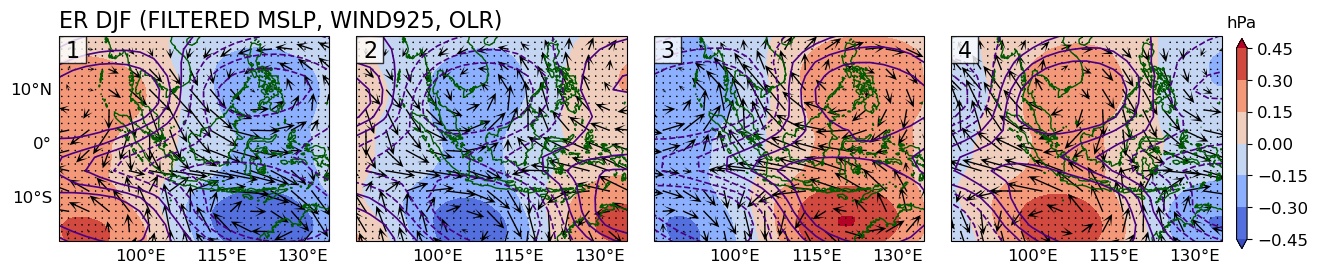

In [14]:
fig = plt.figure(figsize=(15,3.5))
#Plot Composite ER Each Phase
for img, sbp in zip(np.arange(0,4,1), [141,142,143,144]):
    ax = plt.subplot(sbp, projection=ccrs.PlateCarree())
    ax.set_extent([85, 135, -18, 20], crs=ccrs.PlateCarree())
    gl=ax.gridlines(draw_labels=True,linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = tk.FixedLocator([85, 100, 115, 130])
    gl.ylocator = tk.FixedLocator([ -10, 0, 10])
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12} 
    if img>0:
        gl.left_labels = False
    pltctr=ax.contour(lonolrer, latolrer, anolrer.sel(time=np.in1d(anolrer.time, tglereveryph[img])).mean(dim='time'), 
              transform=ccrs.PlateCarree(),
              levels=np.arange(-5,6,2), 
              extend='both', colors='indigo', linewidths=1.2
              )
    dset=anslper/100
    value=dset.sel(time=np.in1d(dset.time, tglereveryph[img])).mean(dim='time')
    plotval=ax.contourf(loner, later, value, transform=ccrs.PlateCarree(),
              cmap='coolwarm',
              levels=np.arange(-0.45, 0.46, 0.15), 
              extend='both'
              )
    x,y=np.meshgrid(loner, later)
    skipp=1
    ax.scatter(x[::skipp,::skipp],y[::skipp,::skipp],pvaluemslptfer[img][::skipp,::skipp]*1*0.5,color='k', linewidth=0.4,)
    uu=anu925er.sel(time=np.in1d(anu925er.time, tglereveryph[img])).mean(dim='time')
    vv=anv925er.sel(time=np.in1d(anv925er.time, tglereveryph[img])).mean(dim='time')
    skip = 3
    Qwd1=ax.quiver(x[::skip, ::skip], y[::skip, ::skip], uu[::skip, ::skip]*pvalueuv925tfer[img][::skip, ::skip], vv[::skip, ::skip]*pvalueuv925tfer[img][::skip, ::skip], color='k', scale=2 ,scale_units='inches', width=0.005, headlength=8.5, headwidth=7.5, headaxislength=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
    if img==0:
        ax.set_title('ER DJF (FILTERED MSLP, WIND925, OLR)', loc='left', fontsize=16)
    longitude1, latitude1 = 85, 15
    longitude2, latitude2 = 90, 20
    ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                            facecolor='white', edgecolor='k', linewidth=1, alpha=0.8, zorder=3,
                            transform=ccrs.PlateCarree()))
    ax.text(86.25,16,str(1+img),fontsize=16, c='k')
    if img==4:
        qk = plt.quiverkey(Qwd1, 
                  0.75, 1.05,                  
                  0.5,str(0.5)+' m/s',   
                  labelpos='E',               
                  coordinates='axes'
                   )   
cbar_ax = fig.add_axes([0.91, 0.18, 0.007, 0.6])
cbar = fig.colorbar(plotval, cax=cbar_ax)
cbar.ax.set_title('hPa', pad=15, fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.subplots_adjust(wspace=0.1)

In [20]:
datasst = xr.open_mfdataset('E:\Data OISST\*.nc',combine = 'by_coords')
datasst=datasst.sel(time=slice('1981-09-01T00:00:00.000000000','2021-05-31T00:00:00.000000000')).sel(lat=slice(-20,22), lon=slice(82,138))
sstdjf=datasst['sst'].sel(time=datasst.time.dt.month.isin([1, 2, 12]))
sstdjfmean=datasst['sst'].sel(time=datasst.time.dt.month.isin([1, 2, 12])).mean(dim='time')
#sstdjf=datasst['sst'].sel(time=datasst.time.dt.month.isin([1, 2])).mean(dim='time')
ansstdjf=sstdjf-sstdjfmean
sstdjfclim=ansstdjf.load()

In [21]:
pvaluesster=np.empty([4, len(sstdjfclim['lat']), len(sstdjfclim['lon'])])
data=sstdjfclim
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglereveryph[c]), 1000, 1)
    compositemean=sstdjfclim.sel(time=np.in1d(sstdjfclim.time, tglereveryph[c])).mean(dim='time')
    pvaluesster[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluessttfer=pvaluesster

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:35<00:00,  6.45it/s]


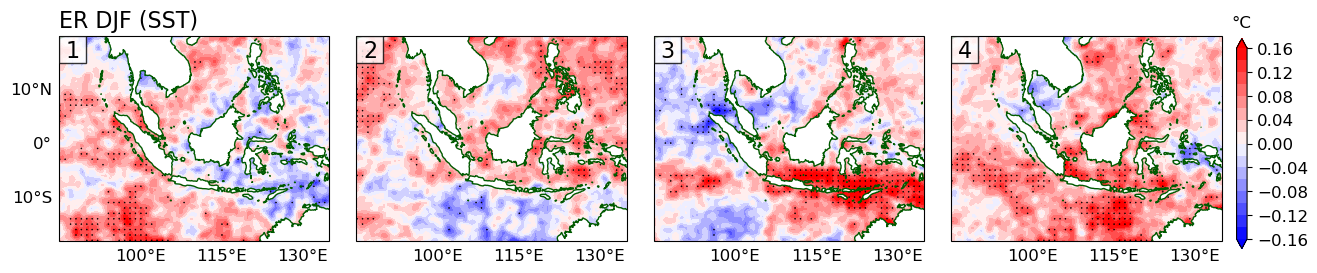

In [31]:
fig = plt.figure(figsize=(15,3.5))
#Plot Composite ER Each Phase
for img, sbp in zip(np.arange(0,4,1), [141,142,143,144]):
    ax = plt.subplot(sbp, projection=ccrs.PlateCarree())
    ax.set_extent([85, 135, -18, 20], crs=ccrs.PlateCarree())
    gl=ax.gridlines(draw_labels=True,linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = tk.FixedLocator([85, 100, 115, 130])
    gl.ylocator = tk.FixedLocator([ -10, 0, 10])
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12} 
    if img>0:
        gl.left_labels = False
   
    dset=sstdjfclim
    value=dset.sel(time=np.in1d(dset.time, tglereveryph[img])).mean(dim='time')
    plotval=ax.contourf(sstdjfclim['lon'], sstdjfclim['lat'], value, transform=ccrs.PlateCarree(),
              cmap='bwr',
              levels=np.arange(-0.16, 0.161, 0.02), 
              extend='both'
              )
    x,y=np.meshgrid(sstdjfclim['lon'], sstdjfclim['lat'])
    skipp=4
    ax.scatter(x[::skipp,::skipp],y[::skipp,::skipp],pvaluessttfer[img][::skipp,::skipp]*1*0.5,color='k', linewidth=0.4,)
  
    ax.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
    if img==0:
        ax.set_title('ER DJF (SST)', loc='left', fontsize=16)
    longitude1, latitude1 = 85, 15
    longitude2, latitude2 = 90, 20
    ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                            facecolor='white', edgecolor='k', linewidth=1, alpha=0.8, zorder=3,
                            transform=ccrs.PlateCarree()))
    ax.text(86.25,16,str(1+img),fontsize=16, c='k') 
cbar_ax = fig.add_axes([0.91, 0.18, 0.007, 0.6])
cbar = fig.colorbar(plotval, cax=cbar_ax)
cbar.ax.set_title('°C', pad=15, fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.subplots_adjust(wspace=0.1)
#plt.savefig('E:\. Disertasi S3 Bismillah\Publikasi\Paper Hubungan CS dan CENS\Gambar/10_MJO ER Spatial.jpg', dpi=400, bbox_inches='tight')

In [32]:
pvaluesst=np.empty([8, len(np.arange(0,len(sstdjfclim['lat']),4)), len(np.arange(0,len(sstdjfclim['lon']),4))])
data=sstdjfclim[:,::4,::4]
for c in range(8):
    low, high = bootstrap_3dxr(data, len(tglmjoeveryph[c]), 1000, 1)
    compositemean=sstdjfclim[:,::4,::4].sel(time=np.in1d(sstdjfclim.time, tglmjoeveryph[c])).mean(dim='time')
    pvaluesst[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluessttf=pvaluesst

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.22it/s]


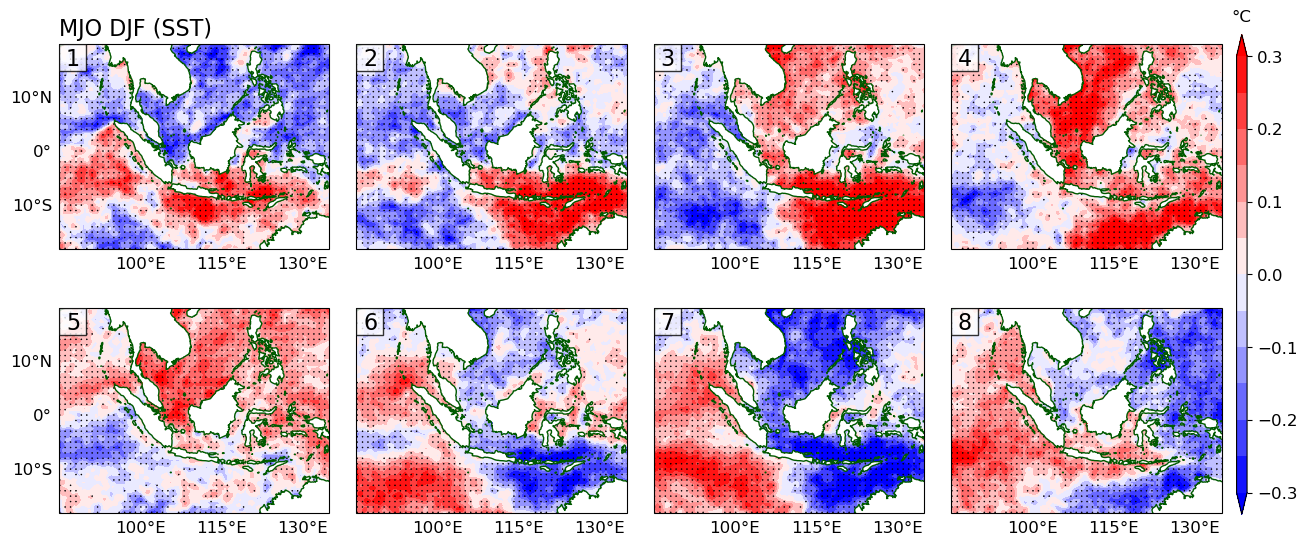

In [37]:
fig = plt.figure(figsize=(15,8))
for img, sbp in zip(np.arange(0,8,1), np.arange(241,249,1)):
    ax = fig.add_subplot(sbp, projection=ccrs.PlateCarree())
    ax.set_extent([85, 135, -18, 20], crs=ccrs.PlateCarree())
    gl=ax.gridlines(draw_labels=True,linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = tk.FixedLocator([85, 100, 115, 130])
    gl.ylocator = tk.FixedLocator([ -10, 0, 10])
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    if img == 1 or img == 2 or img == 3 or img==5 or img==6 or img==7:
        gl.left_labels = False
    dset=sstdjfclim
    value=dset.sel(time=np.in1d(dset.time, tglmjoeveryph[img])).mean(dim='time')
    plotval=ax.contourf(sstdjfclim['lon'], sstdjfclim['lat'], value, transform=ccrs.PlateCarree(),
              cmap='bwr',
              #add_colorbar= False,
              levels=np.arange(-0.3,0.31,0.05), 
              extend='both'
              )
    x,y=np.meshgrid(sstdjfclim['lon'], sstdjfclim['lat'])
    skipp=4
    ax.scatter(x[::skipp,::skipp],y[::skipp,::skipp],pvaluessttf[img]*1*0.5,color='k', linewidth=0.4)
    
    ax.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
    if img==0:
        ax.set_title('MJO DJF (SST)', loc='left', fontsize=16)
    longitude1, latitude1 = 85, 15
    longitude2, latitude2 = 90, 20

    ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                    facecolor='white', edgecolor='k', linewidth=1, alpha=0.8, zorder=3,
                                    transform=ccrs.PlateCarree()))
    ax.text(86.25,16,str(1+img),fontsize=16, c='k')
    
cbar_ax = fig.add_axes([0.91, 0.2, 0.007, 0.6])
cbar = fig.colorbar(plotval, cax=cbar_ax)
cbar.ax.set_title('°C', pad=25, fontsize=12)
cbar.ax.tick_params(labelsize=12)


plt.subplots_adjust(hspace=-0.25, wspace=0.1)
#plt.savefig('E:\Daily Reanalisis ERA 5 v2\Revisi\Fase MJO.jpg', dpi=200, bbox_inches='tight')
#plt.savefig('E:\Daily Reanalisis ERA 5 v2\Gambar Publikasi\Fase MJO.eps', format='eps', bbox_inches='tight')